In [2]:
# Clone the ibm/tsfm
! git clone --depth 1 --branch v0.2.9 https://github.com/IBM/tsfm.git

fatal: destination path 'tsfm' already exists and is not an empty directory.


In [3]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [4]:
 %%capture
# Install the tsfm library
! pip install ".[notebooks]"

%cd ../

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-

In [5]:
!pip install scikit-learn

In [6]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

In [7]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

In [242]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

timestamp_column = "date"
target_columns = ["pm2.5"]
observable_columns = ["DEWP","TEMP","PRES","Iws"]

pollution_data = pd.read_csv(
    "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip"
)

pollution_data['date'] = pd.to_datetime(pollution_data[['year','month','day', 'hour']])

#deal with NA
pollution_data['pm2.5'] = pollution_data['pm2.5'].interpolate()
pollution_data['cbwd'] = pollution_data['cbwd'].astype('category').cat.codes

data_length = len(pollution_data)

train_start_index = 0
train_end_index = round(data_length * 0.8)

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
eval_start_index = round(data_length * 0.8) - context_length
eval_end_index = round(data_length * 0.9)

test_start_index = round(data_length * 0.9) - context_length
test_end_index = data_length

split_config = {
                "train": [0, train_end_index],
                "valid": [eval_start_index, eval_end_index],
                "test": [test_start_index,test_end_index],
            }

#our observable columns are the covariates for our target column
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors, training wants those. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, pollution_data, split_config
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 34433, val = 4797, test = 4797


<Axes: xlabel='date'>

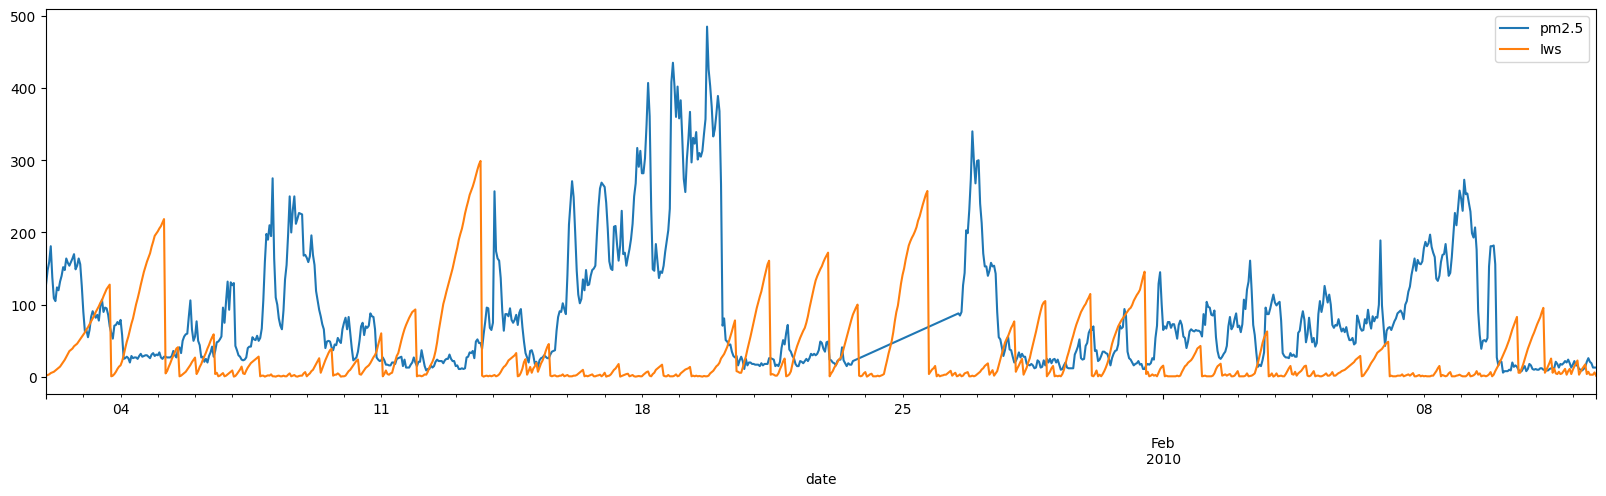

In [241]:
pollution_data[:1000].plot(x="date", y=["pm2.5", "Iws"], figsize=(20,5))

In [206]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.425916463136673,
 'eval_runtime': 24.225,
 'eval_samples_per_second': 198.019,
 'eval_steps_per_second': 24.768}

**Question**: do I need to create a TimeSeriesForecastingPipeline each time I want to get a forecast on test data?

In [207]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

In [208]:
zs_forecast = zs_forecast_pipeline(test_data)

In [250]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [210]:
zs_forecast.head()

,date,pm2.5_prediction,pm2.5
0,2014-07-02 11:00:00,"[-0.5098156332969666, -0.4921243190765381, -0....","[-0.46896618604660034, -0.3803116977214813, -0..."
1,2014-07-02 12:00:00,"[-0.4535684287548065, -0.4456627070903778, -0....","[-0.3803116977214813, -0.35814809799194336, -0..."
2,2014-07-02 13:00:00,"[-0.2918664813041687, -0.29206570982933044, -0...","[-0.35814809799194336, -0.2916572093963623, -0..."
3,2014-07-02 14:00:00,"[-0.2619788944721222, -0.25635209679603577, -0...","[-0.2916572093963623, -0.22516635060310364, -0..."
4,2014-07-02 15:00:00,"[-0.23244306445121765, -0.241120845079422, -0....","[-0.22516635060310364, -0.22516635060310364, -..."


<Axes: >

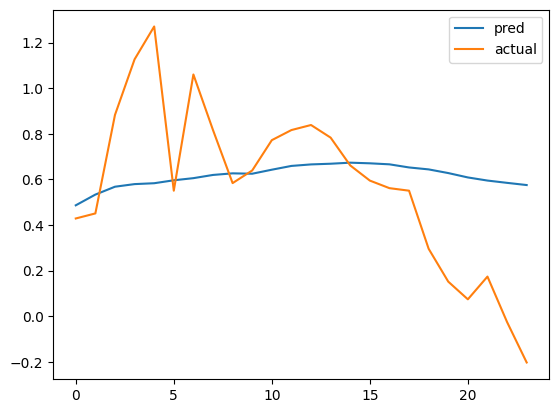

In [211]:
fcast_df = pd.DataFrame({"pred":zs_forecast.loc[50]['pm2.5_prediction'], "actual":zs_forecast.loc[50]['pm2.5'][:24]})
fcast_df.plot()

<Axes: title={'center': '0.8190047813'}, xlabel='date'>

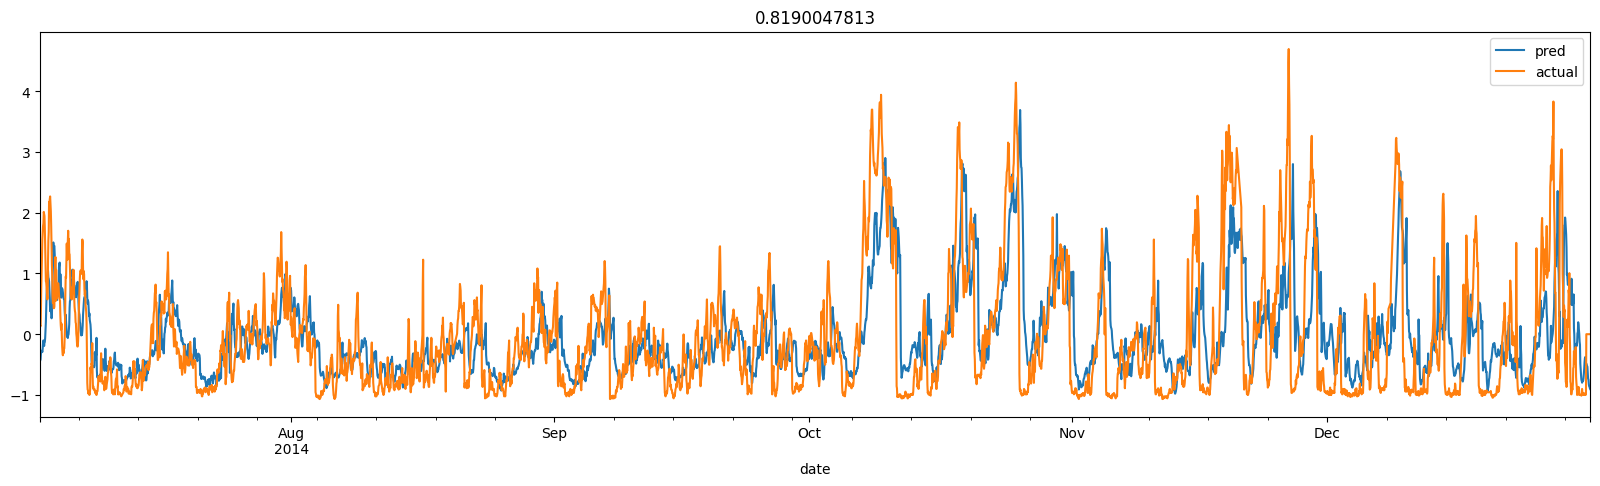

In [257]:
from sklearn.metrics import mean_squared_error

one_day_out_predictions = compare_forecast(zs_forecast, "date", "pm2.5_prediction", "pm2.5", 12)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]

rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))


In [213]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)

In [214]:
# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

In [243]:
# Important parameters
learning_rate = 0.001
num_epochs = 20
batch_size = 64

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.276100,0.275944
2,0.270600,0.278757
3,0.268700,0.276780


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/data

[TrackingCallback] Mean Epoch Time = 225.7901407877604 seconds, Total Train Time = 736.6199052333832


TrainOutput(global_step=1617, training_loss=0.2718206345482085, metrics={'train_runtime': 736.6321, 'train_samples_per_second': 934.876, 'train_steps_per_second': 14.634, 'total_flos': 1277715743539200.0, 'train_loss': 0.2718206345482085, 'epoch': 3.0})

In [244]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.25370854139328003,
 'eval_runtime': 19.491,
 'eval_samples_per_second': 246.114,
 'eval_steps_per_second': 3.848,
 'epoch': 3.0}

In [245]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

In [246]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)
context_length = finetune_forecast_model.config.context_length

In [247]:
forecasts = forecast_pipeline(test_data)

<Axes: >

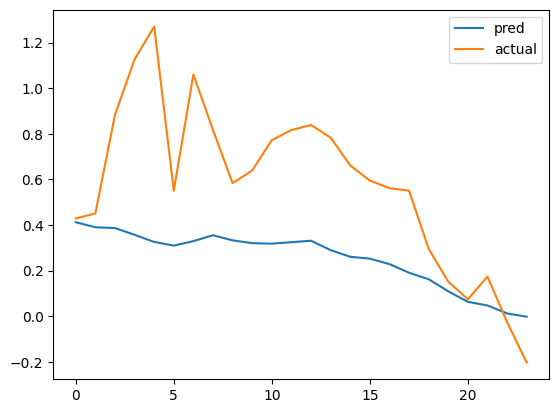

In [248]:
fcast_df = pd.DataFrame({"pred":forecasts.loc[0]['pm2.5_prediction'], "actual":forecasts.loc[0]['pm2.5'][:24]})
fcast_df.plot()

<Axes: title={'center': 'RMSE:0.7875375096'}, xlabel='date'>

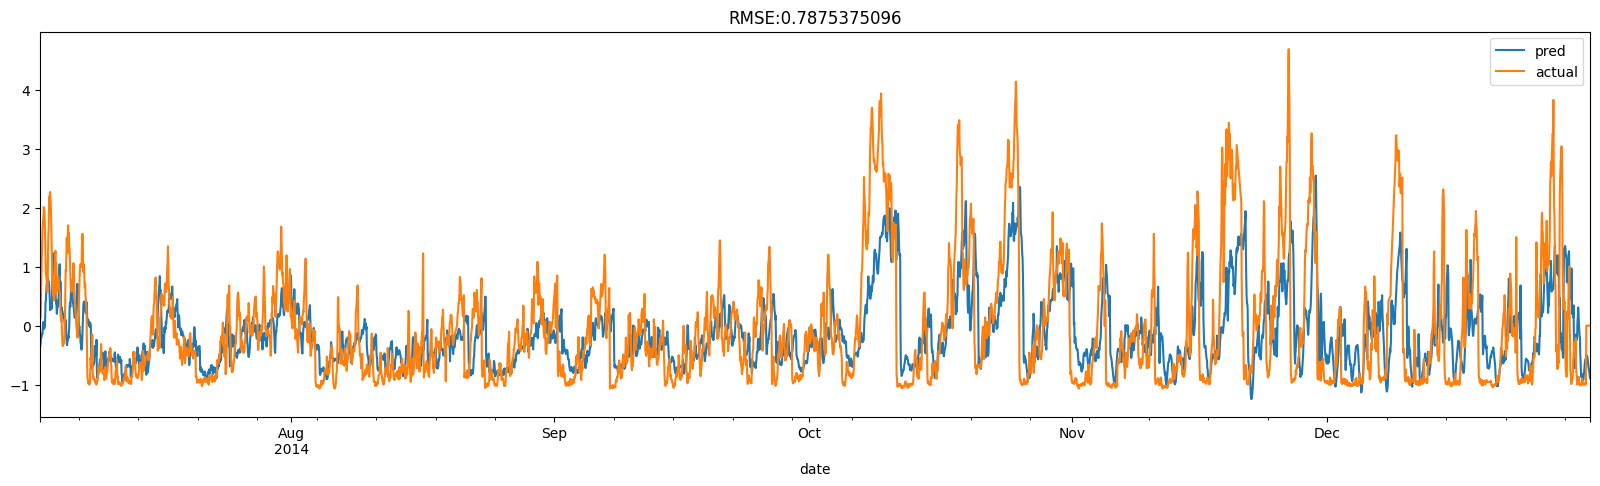

In [258]:
one_day_out_predictions = compare_forecast(forecasts, "date", "pm2.5_prediction", "pm2.5", 12)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]

rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="RMSE:" + str(rms))
